In [1]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 14:14:07.799947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744726447.977464      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744726448.029233      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
!gunzip cc.ta.300.vec.gz
# # !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
# # !gunzip cc.hi.300.vec.gz
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # print(f"Using device: {device}")

--2025-04-15 14:14:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1213735937 (1.1G) [binary/octet-stream]
Saving to: ‘cc.ta.300.vec.gz’

cc.ta.300.vec.gz    100%[===================>]   1.13G   165MB/s    in 5.8s    

2025-04-15 14:14:28 (199 MB/s) - ‘cc.ta.300.vec.gz’ saved [1213735937/1213735937]



In [3]:
# Load each CSV
df_l1 = pd.read_csv("/kaggle/input/tamil-data/train_ta_l1.csv")
df_l3 = pd.read_csv("/kaggle/input/tamil-data/train_ta_l3.csv")

# Majority voting for each label
annotation_cols_1 = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
annotation_cols_3 = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']

def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    if not valid_votes:
        return None
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0

# Add labels
df_l1['label_1'] = df_l1[annotation_cols_1].apply(get_majority_label, axis=1)
df_l3['label_3'] = df_l3[annotation_cols_3].apply(get_majority_label, axis=1)

# Normalize text for both
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_l1['text'] = df_l1['text'].apply(normalize_text)
df_l3['text'] = df_l3['text'].apply(normalize_text)


# Merge by normalized text
df = pd.merge(df_l1[['text', 'label_1']], df_l3[['text', 'label_3']], on='text', how='inner')

# Drop missing labels and ensure integer type
df = df.dropna()
df[['label_1', 'label_3']] = df[['label_1', 'label_3']].astype(int)

# GloVe-based tokenizer
max_features = 4479
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df['text'])
X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_glove = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Labels
label_encoder = LabelEncoder()
# Correct multilabel target matrix (shape: [N, 2])
y = df[['label_1', 'label_3']].values


# Load GloVe embeddings
embeddings_index = {}
with open('cc.ta.300.vec', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_features, embed_size))
for word, i in keras_tokenizer.word_index.items():
    if i < max_features and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

In [4]:
from torch.utils.data import Dataset

class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, label1, label3, tokenizer, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.label1 = label1
        self.label3 = label3
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        try:
            bert_encoded = self.tokenizer.encode_plus(
                self.texts[idx],
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True
            )

            return {
                'input_ids': torch.tensor(bert_encoded['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(bert_encoded['attention_mask'], dtype=torch.long),
                'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),  # or float if needed
                'label_1': torch.tensor(self.label1[idx], dtype=torch.float),
                'label_3': torch.tensor(self.label3[idx], dtype=torch.float),
            }
        except Exception as e:
            print(f"[Dataset error] at idx={idx}: {e}")
            return None

In [5]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [6]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super(FusionClassifier, self).__init__()

        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        # Updated input dimension from 640 → 512
        self.fusion = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5)
        )

        # Two classification heads
        self.classifier_1 = nn.Linear(256, 1)
        self.classifier_3 = nn.Linear(256, 1)

    def forward(self, input_ids, attention_mask, glove_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(glove_input)               # (B, 128)

        # Combine 4-way fusion (512 dims)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2], dim=1)     # (B, 512)
        x = self.fusion(x)                                   # (B, 256)

        out_1 = self.classifier_1(x)
        out_3 = self.classifier_3(x)

        return torch.cat([out_1, out_3], dim=1)

In [ ]:
# # Check if label distributions match
# print("Train label_1 pos:", (train_y[:, 0] == 1).sum())
# print("Val label_1 pos:", (val_y[:, 0] == 1).sum())
# print("Train label_3 pos:", (train_y[:, 1] == 1).sum())
# print("Val label_3 pos:", (val_y[:, 1] == 1).sum())



config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]


Epoch 1/13


Training:   0%|          | 0/341 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Train Loss: 0.6668 | Val Loss: 0.5655
F1 label_1 (gendered):  0.6677
F1 label_3 (explicit):  0.7905
Macro F1:               0.7291
 Saved best model (Macro F1: 0.7291)

Epoch 2/13


Train Loss: 0.5571 | Val Loss: 0.5151
F1 label_1 (gendered):  0.6842
F1 label_3 (explicit):  0.8389
Macro F1:               0.7615
 Saved best model (Macro F1: 0.7615)

Epoch 3/13


Train Loss: 0.4907 | Val Loss: 0.4926
F1 label_1 (gendered):  0.7041
F1 label_3 (explicit):  0.8539
Macro F1:               0.7790
 Saved best model (Macro F1: 0.7790)

Epoch 4/13


Train Loss: 0.4468 | Val Loss: 0.4973
F1 label_1 (gendered):  0.7211
F1 label_3 (explicit):  0.8568
Macro F1:               0.7889
 Saved best model (Macro F1: 0.7889)

Epoch 5/13


Train Loss: 0.4010 | Val Loss: 0.5174
F1 label_1 (gendered):  0.7160
F1 label_3 (explicit):  0.8541
Macro F1:               0.7850

Epoch 6/13


Train Loss: 0.3415 | Val Loss: 0.5534
F1 label_1 (gendered):  0.6824
F1 label_3 (explicit):  0.8505
Macro F1:               0.7664

Epoch 7/13


Train Loss: 0.2684 | Val Loss: 0.6366
F1 label_1 (gendered):  0.6836
F1 label_3 (explicit):  0.8428
Macro F1:               0.7632

Epoch 8/13


/tmp/ipykernel_31/760861703.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_tamil_task3.pt"))


Train Loss: 0.2144 | Val Loss: 0.7258
F1 label_1 (gendered):  0.6526
F1 label_3 (explicit):  0.8364
Macro F1:               0.7445

Final Evaluation




Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Non-Hate       0.84      0.68      0.75       797
        Hate       0.64      0.82      0.72       564

    accuracy                           0.74      1361
   macro avg       0.74      0.75      0.74      1361
weighted avg       0.76      0.74      0.74      1361



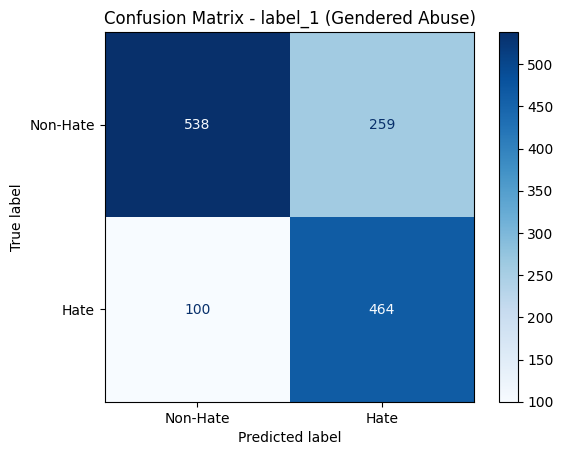


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Non-Hate       0.75      0.71      0.73       487
        Hate       0.84      0.87      0.86       874

    accuracy                           0.81      1361
   macro avg       0.80      0.79      0.79      1361
weighted avg       0.81      0.81      0.81      1361



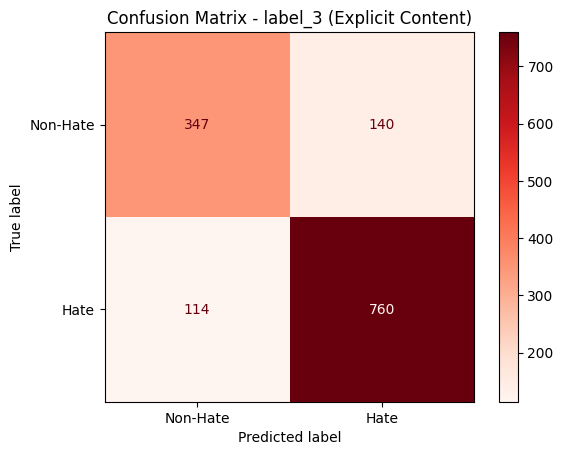

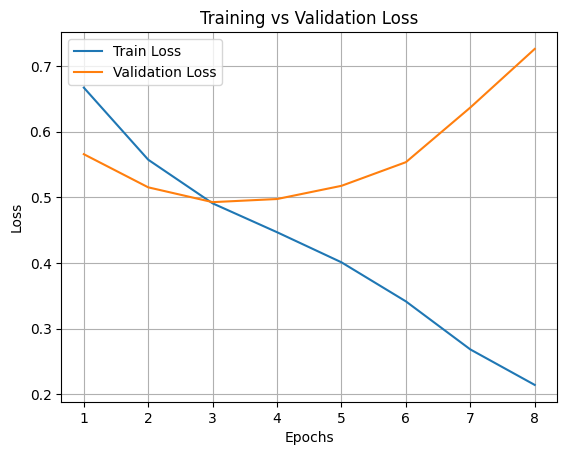

In [7]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# Train/val split
train_texts, val_texts, train_glove, val_glove, train_y, val_y = train_test_split(
    df['text'].tolist(), X_glove, y, test_size=0.2, random_state=42
)


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and DataLoaders
train_dataset = FusionDataset(train_texts, train_glove, train_y[:, 0], train_y[:, 1], tokenizer)
val_dataset = FusionDataset(val_texts, val_glove, val_y[:, 0], val_y[:, 1], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = FusionClassifier(embedding_matrix).to(device)

optimizer = AdamW([
    {"params": model.bert_encoder.bert.parameters(), "lr": 5e-6},
    {"params": model.fusion.parameters(), "lr": 1e-4},
    {"params": model.classifier_1.parameters(), "lr": 1e-4},
    {"params": model.classifier_3.parameters(), "lr": 1e-4},
    {"params": model.bert_encoder.linear.parameters(), "lr": 1e-4},
])
criterion = nn.BCEWithLogitsLoss()


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training
train_losses, val_losses = [], []
best_f1 = 0.0
best_val_loss = float('inf')

for epoch in range(8):
    print(f"\nEpoch {epoch + 1}/13")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        out_1 = outputs[:, 0].unsqueeze(1)
        out_3 = outputs[:, 1].unsqueeze(1)

        loss_1 = criterion(out_1, label_1)
        loss_3 = criterion(out_3, label_3)
        loss = 0.7 * loss_1 + 0.3 * loss_3

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
            label_1 = batch["label_1"].unsqueeze(1).to(device)
            label_3 = batch["label_3"].unsqueeze(1).to(device)

            outputs = model(**inputs)
            out_1 = outputs[:, 0].unsqueeze(1)
            out_3 = outputs[:, 1].unsqueeze(1)

            loss_1 = criterion(out_1, label_1)
            loss_3 = criterion(out_3, label_3)
            val_loss += (0.7 * loss_1 + 0.3 * loss_3).item()

            probs = torch.sigmoid(outputs)
            preds += (probs > 0.5).int().cpu().tolist()
            targets += torch.cat([label_1, label_3], dim=1).cpu().int().tolist()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    # Metrics
    preds = np.array(preds)
    targets = np.array(targets)

    preds_label_1 = preds[:, 0]
    targets_label_1 = targets[:, 0]
    preds_label_3 = preds[:, 1]
    targets_label_3 = targets[:, 1]

    f1_1 = f1_score(targets_label_1, preds_label_1)
    f1_3 = f1_score(targets_label_3, preds_label_3)
    macro_f1 = f1_score(targets, preds, average="macro")

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"F1 label_1 (gendered):  {f1_1:.4f}")
    print(f"F1 label_3 (explicit):  {f1_3:.4f}")
    print(f"Macro F1:               {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "fusion_tamil_task3.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f" Saved best model (Macro F1: {best_f1:.4f})")

# ============================
#  Final Evaluation Report
# ============================

print("\nFinal Evaluation\n")
model.load_state_dict(torch.load("fusion_tamil_task3.pt"))
model.eval()

final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        probs = torch.sigmoid(outputs)
        final_preds += (probs > 0.5).int().cpu().tolist()
        final_targets += torch.cat([label_1, label_3], dim=1).cpu().int().tolist()

# Classification Report & Confusion Matrix
final_preds = np.array(final_preds)
final_targets = np.array(final_targets)

for i, label in enumerate(["label_1 (Gendered Abuse)", "label_3 (Explicit Content)"]):
    y_true = final_targets[:, i]
    y_pred = final_preds[:, i]
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_true, y_pred, target_names=["Non-Hate", "Hate"]))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap="Blues" if i == 0 else "Reds")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()

# ============================
#  Loss Plot
# ============================

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_31/1739816656.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_tamil_task3.pt"))



Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Not Hate       0.84      0.68      0.75       797
        Hate       0.64      0.82      0.72       564

    accuracy                           0.74      1361
   macro avg       0.74      0.75      0.74      1361
weighted avg       0.76      0.74      0.74      1361


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Not Hate       0.75      0.71      0.73       487
        Hate       0.84      0.87      0.86       874

    accuracy                           0.81      1361
   macro avg       0.80      0.79      0.79      1361
weighted avg       0.81      0.81      0.81      1361


Confusion Matrix for label_1:


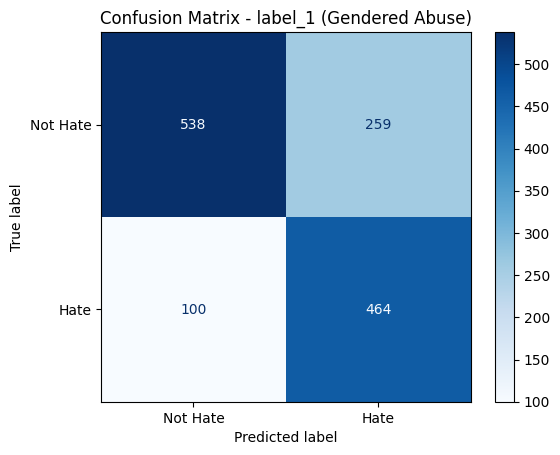


Confusion Matrix for label_3:


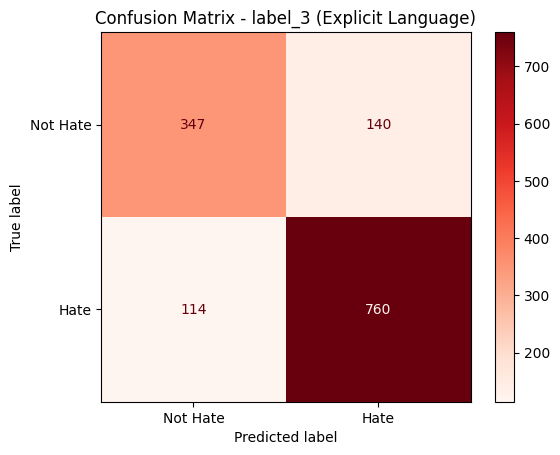

In [8]:
# Load best model
model.load_state_dict(torch.load("fusion_tamil_task3.pt"))
model.eval()

final_preds, final_targets = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)                         # (B, 2)
        probs = torch.sigmoid(outputs)                    # (B, 2)
        preds = (probs > 0.5).int().cpu().tolist()        # threshold
        final_preds.extend(preds)
        final_targets.extend(torch.cat([label_1, label_3], dim=1).cpu().int().tolist())
 

# Convert to NumPy arrays
final_preds = np.array(final_preds)
final_targets = np.array(final_targets)

# Split per label
preds_label_1 = final_preds[:, 0]
targets_label_1 = final_targets[:, 0]
preds_label_3 = final_preds[:, 1]
targets_label_3 = final_targets[:, 1]

# Print classification reports
print("\nClassification Report for label_1 (Gendered Abuse):")
print(classification_report(targets_label_1, preds_label_1, target_names=["Not Hate", "Hate"]))

print("\nClassification Report for label_3 (Explicit Content):")
print(classification_report(targets_label_3, preds_label_3, target_names=["Not Hate", "Hate"]))

# Confusion matrices
cm1 = confusion_matrix(targets_label_1, preds_label_1)
cm2 = confusion_matrix(targets_label_3, preds_label_3)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["Not Hate", "Hate"])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Not Hate", "Hate"])

print("\nConfusion Matrix for label_1:")
disp1.plot(cmap="Blues")
plt.title("Confusion Matrix - label_1 (Gendered Abuse)")
plt.show()

print("\nConfusion Matrix for label_3:")
disp2.plot(cmap="Reds")
plt.title("Confusion Matrix - label_3 (Explicit Language)")
plt.show()


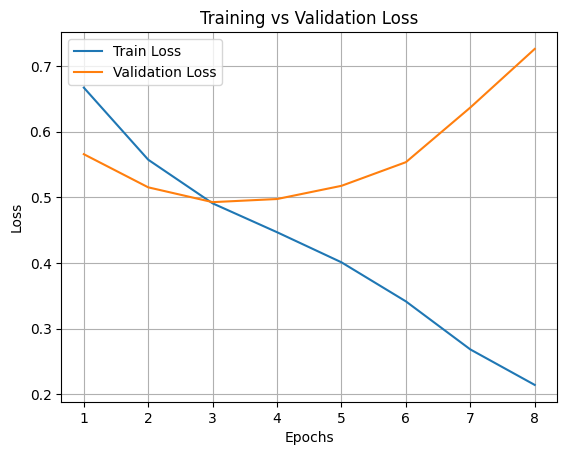

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/435271104.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/fusion_tamil_task3.pt"))


Saved predictions to: Task1_output_Multilabel.csv

Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Not Hate       0.77      0.74      0.75       548
        Hate       0.77      0.79      0.78       587

    accuracy                           0.77      1135
   macro avg       0.77      0.77      0.77      1135
weighted avg       0.77      0.77      0.77      1135



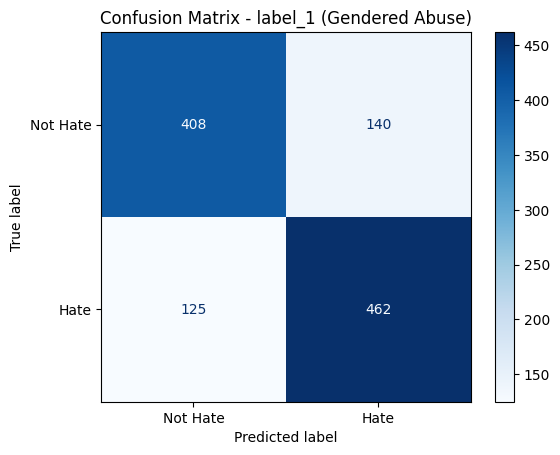


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Not Hate       0.72      0.74      0.73       359
        Hate       0.88      0.87      0.87       776

    accuracy                           0.83      1135
   macro avg       0.80      0.80      0.80      1135
weighted avg       0.83      0.83      0.83      1135



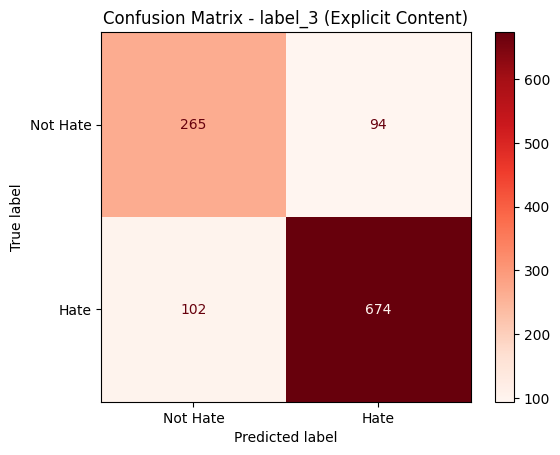


Macro F1-score: 0.8251 | Precision: 0.8225 | Recall: 0.8278


In [15]:
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess test data
test_l1 = pd.read_csv("/kaggle/input/tamil-data/test_ta_l1.csv", engine="python")
test_l3 = pd.read_csv("/kaggle/input/tamil-data/test_ta_l3.csv", engine="python")

annotation_cols_1 = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5']
annotation_cols_3 = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5']

test_l1['label_1'] = test_l1[annotation_cols_1].apply(get_majority_label, axis=1)
test_l3['label_3'] = test_l3[annotation_cols_3].apply(get_majority_label, axis=1)

test_l1['text'] = test_l1['text'].apply(normalize_text)
test_l3['text'] = test_l3['text'].apply(normalize_text)

# Merge both test sets on normalized text
test_df = pd.merge(test_l1[['text', 'label_1']], test_l3[['text', 'label_3']], on='text', how='inner')
test_df.dropna(inplace=True)
test_df[['label_1', 'label_3']] = test_df[['label_1', 'label_3']].astype(int)

# Encode for GloVe + HurtLex
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_label1 = test_df['label_1'].values
test_label3 = test_df['label_3'].values
# test_hurtlex = np.array([get_hurtlex_vector(text) for text in test_df['text']])

# Dataset & DataLoader
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_label1, test_label3, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix).to(device)
model.load_state_dict(torch.load("/kaggle/working/fusion_tamil_task3.pt"))
model.eval()

# Inference
all_preds, all_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int().cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(torch.cat([label_1, label_3], dim=1).cpu().int().tolist())

# Save predictions
output_df = pd.DataFrame({
    'id': np.arange(1, len(all_preds)+1),
    'label_1': [p[0] for p in all_preds],
    'label_3': [p[1] for p in all_preds]
})
output_df.to_csv('/kaggle/working/Task1_output_Multilabel.csv', index=False)
print("Saved predictions to: Task1_output_Multilabel.csv")

# Evaluation
preds = np.array(all_preds)
targets = np.array(all_targets)

for i, label_name in enumerate(["label_1 (Gendered Abuse)", "label_3 (Explicit Content)"]):
    y_true = targets[:, i]
    y_pred = preds[:, i]
    print(f"\nClassification Report for {label_name}:")
    print(classification_report(y_true, y_pred, target_names=["Not Hate", "Hate"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
    disp.plot(cmap="Blues" if i == 0 else "Reds")
    plt.title(f"Confusion Matrix - {label_name}")
    plt.show()

# Overall scores
f1_macro = f1_score(targets, preds, average="macro")
precision_macro = precision_score(targets, preds, average="macro")
recall_macro = recall_score(targets, preds, average="macro")

print(f"\nMacro F1-score: {f1_macro:.4f} | Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f}")
